# Notebook Versions

- Version 1 (06/30/2024)

    * EDA and Baseline Modeling 1.0.
    

- Version 2 (07/02/2024)

    * Baseline Modeling 1.0 updated.
    
    
- Version 3 (07/02/2024)

    * Fixing bug.
    
    
- Version 4 (07/08/2024)

    * Updating Baseline Modeling 1.0.


- Version 5 (07/08/2024)

    * Baseline Modeling 2.0 added.
    
    
- Version 6 (07/08/2024)
    * Fixing bug.
    
    
- Version 7 (07/08/2024)
    * Fixing bug.
    
    
- Version 8 (07/08/2024)
    * Fixing bug.
    * Updating Baseline Modeling 2.0.
    

- Version 9 (07/17/2024)
    * Baseline Modeling 3.0 added.

# Loading Libraries

In [1]:
# %load_ext cudf.pandas

In [2]:
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

import gc

import warnings
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm

import re

from functools import partial
from scipy.stats import kurtosis, skew, gmean, mode

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns
import plotly.express as px

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, FunctionTransformer, PowerTransformer, PolynomialFeatures
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import KNNImputer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, RepeatedStratifiedKFold, cross_val_score, cross_val_predict, RepeatedKFold
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, cohen_kappa_score, log_loss, f1_score, r2_score, accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Ridge, RidgeCV
from collections import Counter
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC, LinearSVR

from category_encoders import TargetEncoder

import xgboost as xgb

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.neural_network import MLPClassifier

import optuna

# Reading Data Files

In [3]:
train = pd.read_csv('../input/playground-series-s4e7/train.csv', index_col=0)
test = pd.read_csv('../input/playground-series-s4e7/test.csv', index_col=0)

print('The dimension of the train dataset is:', train.shape)
print('The dimension of the test dataset is:', test.shape)

The dimension of the train dataset is: (11504798, 11)
The dimension of the test dataset is: (7669866, 10)


In [4]:
train.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


In [5]:
test.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
id,,,,,,,,,,
11504798,Female,20,1,47.0,0,< 1 Year,No,2630.0,160.0,228
11504799,Male,47,1,28.0,0,1-2 Year,Yes,37483.0,124.0,123
11504800,Male,47,1,43.0,0,1-2 Year,Yes,2630.0,26.0,271
11504801,Female,22,1,47.0,1,< 1 Year,No,24502.0,152.0,115
11504802,Male,51,1,19.0,0,1-2 Year,No,34115.0,124.0,148


First, let's check for missing values in the `train` and `test` data frames.

In [6]:
train.isnull().sum()

Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [7]:
test.isnull().sum()

Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
dtype: int64

There are no missing values neither in the `train` or `test` data frames. Next, we check for duplicates.

In [8]:
print(f"There are {sum(train.duplicated())} duplicated rows in the train data frame.")

print("\n")
print(f"After dropping the Response column, there are {sum(train.drop(columns=['Response']).duplicated())} duplicated rows in the train data frame.")

print("\n")
print(f"There are {sum(test.duplicated())} duplicated rows in the test data frame.")

There are 0 duplicated rows in the train data frame.


After dropping the Response column, there are 0 duplicated rows in the train data frame.


There are 0 duplicated rows in the test data frame.


Finally, we check if there are any observations that appear in both the `train` and `test` data frames.

In [9]:
temp_train = train.drop(columns=['Response'], axis=1)
temp_test = test

inner_join = pd.merge(temp_train, temp_test)
print(f"There are {inner_join.shape[0]} observations that appear in both the train and test data frames")

There are 0 observations that appear in both the train and test data frames


# Data Exploration

First, we start by exploring the `Response` feature.

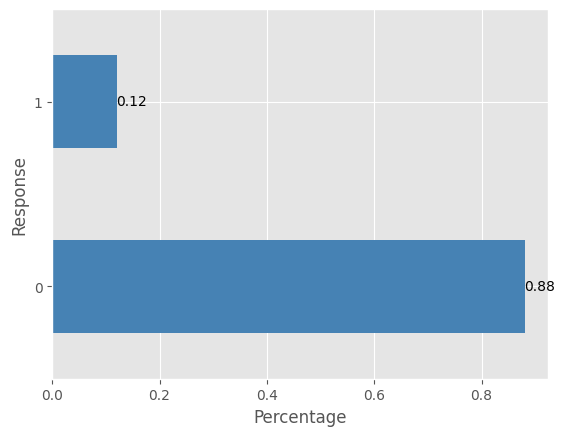

In [10]:
ax = round(train['Response'].value_counts(normalize=True), 2).plot(kind='barh', color='steelblue')
ax.bar_label(ax.containers[0], label_type='edge')
ax.margins(y=0.1)
plt.xlabel('Percentage');

From the above chart, we see that this is an imbalanced dataset. `Response = 1` is the less frequent label. Next, we explore the relationships between the input features and `Response`.

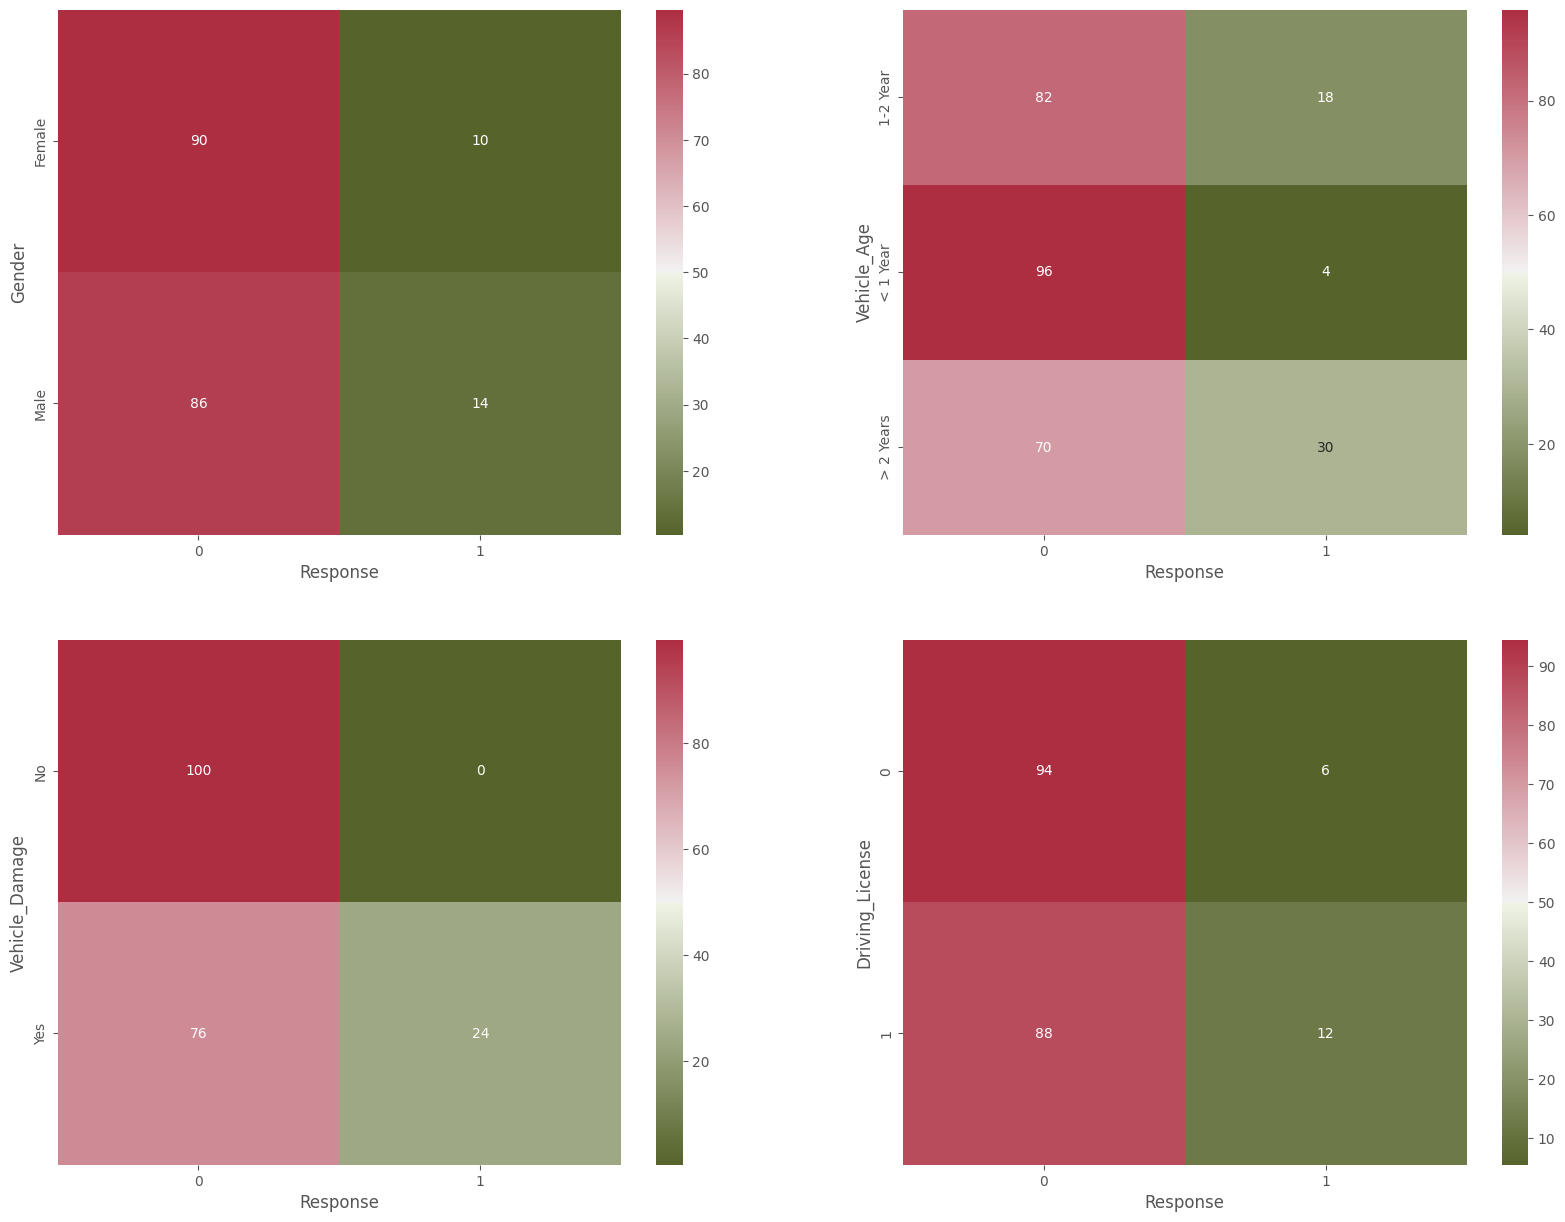

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15))

cmap = sns.diverging_palette(100, 7, s = 75, l = 40, n = 5, center = 'light', as_cmap = True)

sns.heatmap(data=round(100*pd.crosstab(train['Gender'], train['Response'], normalize=0), 2), annot=True, cmap=cmap, fmt='.0f', ax=axes[0, 0])
sns.heatmap(data=round(100*pd.crosstab(train['Vehicle_Age'], train['Response'], normalize=0), 2), annot=True, cmap=cmap, fmt='.0f', ax=axes[0, 1])
sns.heatmap(data=round(100*pd.crosstab(train['Vehicle_Damage'], train['Response'], normalize=0), 2), annot=True, cmap=cmap, fmt='.0f', ax=axes[1, 0]);
sns.heatmap(data=round(100*pd.crosstab(train['Driving_License'], train['Response'], normalize=0), 2), annot=True, cmap=cmap, fmt='.0f', ax=axes[1, 1]);

These are a couple of observations from the above charts:

- Males a litle more likely to have `Response = 1` than females.
- The older the car is, the more likely `Response = 1` is.

It seems that `Region_Code`, `Policy_Sales_Channel`, `Vintage` are categorical features. Let's check of the vales in each of those features are consistent across the `train` and `test` datasets.

In [12]:
print(f"There are {sum(~np.isin(test['Region_Code'].unique(), train['Region_Code'].unique()))} labels in Region_Code in the test dataset that don't appear in the train dataset.")
print(f"There are {sum(~np.isin(test['Policy_Sales_Channel'].unique(), train['Policy_Sales_Channel'].unique()))} labels in Policy_Sales_Channel in the test dataset that don't appear in the train dataset.")
print(f"There are {sum(~np.isin(test['Vintage'].unique(), train['Vintage'].unique()))} labels in Vintage in the test dataset that don't appear in the train dataset.")

There are 0 labels in Region_Code in the test dataset that don't appear in the train dataset.
There are 2 labels in Policy_Sales_Channel in the test dataset that don't appear in the train dataset.
There are 0 labels in Vintage in the test dataset that don't appear in the train dataset.


Let's identify those `Policy_Sales_Channel` labels in the `test` dataset that don't appear in the `train` dataset.

In [13]:
test['Policy_Sales_Channel'].unique()[~np.isin(test['Policy_Sales_Channel'].unique(), train['Policy_Sales_Channel'].unique())]

array([149., 144.])

Let's replace those labels as follows.

In [14]:
test['Policy_Sales_Channel'] = np.where(test['Policy_Sales_Channel']==144., 145., test['Policy_Sales_Channel'])
test['Policy_Sales_Channel'] = np.where(test['Policy_Sales_Channel']==149., 150., test['Policy_Sales_Channel'])

Next, we explore the distribution of `Age`.

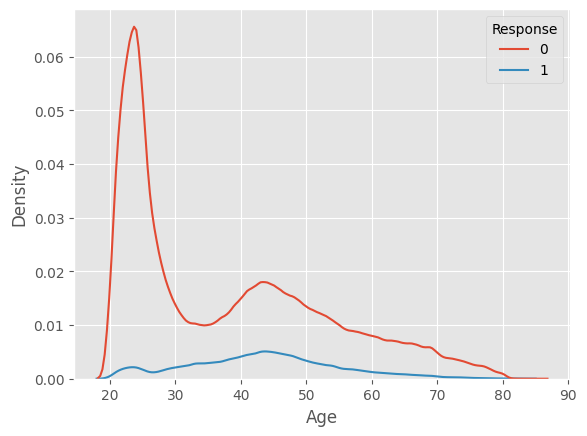

In [15]:
sns.kdeplot(data=train, x='Age', hue='Response');

From the above chart, the distributions of `Age` are similar. Next, we explore the distribution of `Annual_Premium`.

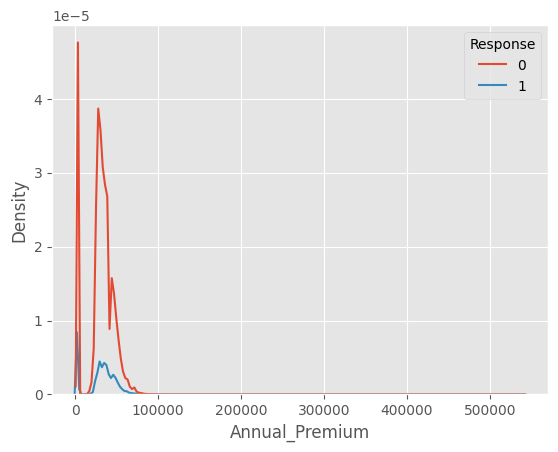

In [16]:
sns.kdeplot(data=train, x='Annual_Premium', hue='Response');

From the above chart, the distributions of `Annual_Premium` are similar.

In [17]:
gc.collect()

3755

# Baseline Modeling 1.0

First, we pre-process the data as follows. 

In [18]:
%%time
def converting_datatypes(df, df_train=False):
    
    df = df.copy()

    df['Age'] = df['Age'].astype('int8')
    df['Driving_License'] = df['Driving_License'].astype('int8')
    df['Region_Code'] = df['Region_Code'].astype('int8')
    df['Previously_Insured'] = df['Previously_Insured'].astype('int8')
    df['Annual_Premium'] = df['Annual_Premium'].astype('int32')
    df['Policy_Sales_Channel'] = df['Policy_Sales_Channel'].astype('int16')
    df['Vintage'] = df['Vintage'].astype('int16')
    df['Gender'] = df['Gender'].map({'Female': 0, 'Male': 1}).astype('int8')
    df['Vehicle_Age'] = df['Vehicle_Age'].map({'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 3}).astype('int8')
    df['Vehicle_Damage'] = df['Vehicle_Damage'].map({'No': 0, 'Yes': 1}).astype('int8')

    if df_train==True:

        df['Response'] = df['Response'].astype('int8')

    return df

train = pd.read_csv('../input/playground-series-s4e7/train.csv', index_col=0)
train = converting_datatypes(train, df_train=True)

CPU times: user 16.6 s, sys: 2.53 s, total: 19.1 s
Wall time: 19.1 s


Then, we define the input and target feature for modeling purposes.

In [19]:
%%time
X = train.drop(columns=['Response'], axis=1)
Y = train['Response']

skf = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=42)

CPU times: user 305 ms, sys: 37.1 ms, total: 342 ms
Wall time: 343 ms


Then, we define a basic model (`LogisticRegression`) and run a cross-validation routine.

In [20]:
%%time
LR_md = Pipeline([('stand', StandardScaler()), 
                  ('LR', LogisticRegression(C=0.1,
                                            solver='newton-cholesky'))])

LR_cv = cross_val_score(LR_md, X, Y, cv=skf, scoring='roc_auc', n_jobs=-1)

print(f"The 10-fold average oof ROC-AUC score of the Logistic Regression model is {LR_cv.mean()}")
print(f"The 10-fold std oof ROC-AUC score of the Logistic Regression model is {LR_cv.std()}")
gc.collect()

The 10-fold average oof ROC-AUC score of the Logistic Regression model is 0.830313654466828
The 10-fold std oof ROC-AUC score of the Logistic Regression model is 0.0004703269630647106
CPU times: user 3.79 s, sys: 1.68 s, total: 5.48 s
Wall time: 1min 19s


4006

It's worth noting that in the above model discussed, all features were treated as numeric (or integers). However, as per the data description, features like `Region_Code`, `Policy_Sales_Channel`, and a few others are actually categorical. This shift in feature nature is a crucial step in our model building process, and we'll be using `TargetEncoder` to model these features and further improve model performance.

In [21]:
%%time
def converting_datatypes(df, df_train=False):
    
    df = df.copy()
    
    if df_train==False:
        
        df['Policy_Sales_Channel'] = np.where(df['Policy_Sales_Channel']==144., 145., df['Policy_Sales_Channel'])
        df['Policy_Sales_Channel'] = np.where(df['Policy_Sales_Channel']==149., 150., df['Policy_Sales_Channel'])

    keys = np.sort(df['Region_Code'].unique()).tolist()
    values = [i for i in keys]
    region_code_dictionary = {}
    for key, value in zip(keys, values):
        region_code_dictionary[key] = 'code_' + str(value)

    keys = np.sort(df['Policy_Sales_Channel'].unique()).tolist()
    values = [i for i in keys]
    sales_channel_dictionary = {}
    for key, value in zip(keys, values):
        sales_channel_dictionary[key] = 'code_' + str(value)
    
    df['Age'] = df['Age'].astype('int8')
    df['Driving_License'] = df['Driving_License'].astype('int8')
    df['Region_Code'] = df['Region_Code'].map(region_code_dictionary).astype('category')
    df['Previously_Insured'] = df['Previously_Insured'].astype('int8')
    df['Annual_Premium'] = df['Annual_Premium'].astype('int32')
    df['Policy_Sales_Channel'] = df['Policy_Sales_Channel'].map(sales_channel_dictionary).astype('category')
    df['Vintage'] = df['Vintage'].astype('int16')
    df['Gender'] = df['Gender'].astype('category')
    df['Vehicle_Age'] = df['Vehicle_Age'].astype('category')
    df['Vehicle_Damage'] = df['Vehicle_Damage'].astype('category')

    if df_train==True:

        df['Response'] = df['Response'].astype('int8')

    return df

train = pd.read_csv('../input/playground-series-s4e7/train.csv', index_col=0)
train = converting_datatypes(train, df_train=True)

X = train.drop(columns=['Response'], axis=1)
Y = train['Response']

step_1 = ColumnTransformer([('stand', StandardScaler(), ['Age', 'Annual_Premium', 'Vintage'])],
                            remainder='passthrough', verbose_feature_names_out=False).set_output(transform='pandas')

step_2 = ColumnTransformer([('poly', PolynomialFeatures(include_bias=False),
                            ['Age', 'Annual_Premium', 'Vintage'])],
                            remainder='passthrough', verbose_feature_names_out=False).set_output(transform='pandas')

step_3 = ColumnTransformer([('target_encoder', TargetEncoder(smoothing=30), ['Gender', 'Vehicle_Age', 'Vehicle_Damage', 
                                                                             'Region_Code', 'Policy_Sales_Channel'])],
                            remainder='passthrough').set_output(transform='pandas')

feature_trans = Pipeline([('step-1', step_1),
                          ('step-2', step_2),
                          ('step-3', step_3)])

LR_md = Pipeline([('transformations', feature_trans),
                  ('LR', LogisticRegression(C=0.1,
                                            solver='newton-cholesky'))])

LR_cv = cross_val_score(LR_md, X, Y, cv=skf, scoring='roc_auc', n_jobs=-1)

print(f"The 10-fold average oof ROC-AUC score of the Logistic Regression model is {LR_cv.mean()}")
print(f"The 10-fold std oof ROC-AUC score of the Logistic Regression model is {LR_cv.std()}")

The 10-fold average oof ROC-AUC score of the Logistic Regression model is 0.8528281285012664
The 10-fold std oof ROC-AUC score of the Logistic Regression model is 0.00048586136810261277
CPU times: user 22.8 s, sys: 4.94 s, total: 27.8 s
Wall time: 4min 53s


In [22]:
%%time
LR_fit = LR_md.fit(X, Y)

test_cv = converting_datatypes(test, df_train=False)
LR_pred = LR_fit.predict_proba(test_cv)[:, 1]

submission = pd.read_csv('../input/playground-series-s4e7/sample_submission.csv')
submission['Response'] = LR_pred
submission.head()

CPU times: user 1min 36s, sys: 20.9 s, total: 1min 57s
Wall time: 1min 34s


,id,Response
0,11504798,0.011655
1,11504799,0.352271
2,11504800,0.270829
3,11504801,0.000286
4,11504802,0.055286


In [23]:
submission.to_csv('baseline_sub_1.csv', index=False)
gc.collect()

85

# Baseline Modeling 2.0

First, we preprocess the data as follows.

In [24]:
%%time
def converting_datatypes(df, df_train=False):
    
    df = df.copy()
    
    if df_train==False:
        
        df['Policy_Sales_Channel'] = np.where(df['Policy_Sales_Channel']==144., 145., df['Policy_Sales_Channel'])
        df['Policy_Sales_Channel'] = np.where(df['Policy_Sales_Channel']==149., 150., df['Policy_Sales_Channel'])
    
    df['Age'] = df['Age'].astype('int8')
    df['Driving_License'] = df['Driving_License'].astype('int8')
    df['Region_Code'] = df['Region_Code'].astype('int8')
    df['Previously_Insured'] = df['Previously_Insured'].astype('int8')
    df['Annual_Premium'] = df['Annual_Premium'].astype('int32')
    df['Policy_Sales_Channel'] = df['Policy_Sales_Channel'].astype('int16')
    df['Vintage'] = df['Vintage'].astype('int16')

    df['Gender'] = df['Gender'].map({'Female': 0, 'Male': 1}).astype('int8')

    df['Vehicle_Age'] = df['Vehicle_Age'].map({'< 1 Year': 0, 
                                               '1-2 Year': 1,
                                               '> 2 Years': 2}).astype('int8')

    df['Vehicle_Damage'] = df['Vehicle_Damage'].map({'No': 0, 'Yes': 1}).astype('int8')

    if df_train==True:

        df['Response'] = df['Response'].astype('int8')

    return df

train = pd.read_csv('../input/playground-series-s4e7/train.csv', index_col=0)
train = converting_datatypes(train, df_train=True)

test = pd.read_csv('../input/playground-series-s4e7/test.csv', index_col=0)
test = converting_datatypes(test, df_train=False)

X = train.drop(columns=['Response'], axis=1)
Y = train['Response']

CPU times: user 27.5 s, sys: 4.17 s, total: 31.6 s
Wall time: 31.6 s


Then, we run the usual cross-validation over 10-folds using a tuned `XGBClassififer` model.

In [25]:
%%time
params = {'device': 'cuda',
          'max_depth': 15, 
          'learning_rate': 0.05685820957612027, 
          'gamma': 0.03555294130911486, 
          'alpha': 3.08060204795093, 
          'min_child_weight': 83, 
          'max_bin': 10000, 
          'colsample_bytree': 0.948672654438626, 
          'subsample': 0.7661213515695401, 
          'n_jobs': -1}

skf = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=42)
scores, test_preds = list(), list()
for i, (train_index, test_index) in enumerate(skf.split(X, Y)):
    
    print(f"------------ Working on Fold {i} ------------")
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y[train_index], Y.iloc[test_index]
            
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_test, label=y_test)
    dtest = xgb.DMatrix(test)
            
    xgb_md = xgb.train(params, dtrain, num_boost_round=500, evals=[(dvalid, 'validation')], verbose_eval=False)
    preds = xgb_md.predict(dvalid)
    score = roc_auc_score(y_test, preds)
    print(f"The oof ROC-AUC score is {score}")
    scores.append(score)
    
    test_preds.append(xgb_md.predict(dtest))
    
print(f"The 10-fold average oof ROC-AUC score of the XGBClassifier model is {np.mean(scores)}")
print(f"The 10-fold std oof ROC-AUC score of the XGBClassifier model is {np.std(scores)}")

------------ Working on Fold 0 ------------
The oof ROC-AUC score is 0.8855562832281489
------------ Working on Fold 1 ------------
The oof ROC-AUC score is 0.8857512805974903
------------ Working on Fold 2 ------------
The oof ROC-AUC score is 0.8857288142109003
------------ Working on Fold 3 ------------
The oof ROC-AUC score is 0.8852139411864459
------------ Working on Fold 4 ------------
The oof ROC-AUC score is 0.8853219992145747
------------ Working on Fold 5 ------------
The oof ROC-AUC score is 0.8860572414718169
------------ Working on Fold 6 ------------
The oof ROC-AUC score is 0.8853326816180389
------------ Working on Fold 7 ------------
The oof ROC-AUC score is 0.8856468192729403
------------ Working on Fold 8 ------------
The oof ROC-AUC score is 0.886460027258858
------------ Working on Fold 9 ------------
The oof ROC-AUC score is 0.886183136881322
The 10-fold average oof ROC-AUC score of the XGBClassifier model is 0.8857252224940536
The 10-fold std oof ROC-AUC score o

In [26]:
%%time
submission = pd.read_csv('../input/playground-series-s4e7/sample_submission.csv')
submission['Response'] = np.mean(test_preds, axis=0)
submission.head()

CPU times: user 1.68 s, sys: 96 ms, total: 1.77 s
Wall time: 1.78 s


,id,Response
0,11504798,-0.000204
1,11504799,0.508107
2,11504800,0.250753
3,11504801,0.001874
4,11504802,0.092215


In [27]:
submission.to_csv('baseline_sub_2.csv', index=False)
gc.collect()

71

# Baseline Modeling 3.0

First, we preprocess the data as follows. Notice that we indclude four interactions features as suggested in [here](https://www.kaggle.com/code/rohanrao/automl-grand-prix-1st-place-solution).

In [28]:
def converting_datatypes(df, df_train=False):
    
    df = df.copy()
    
    if df_train==False:
        
        df['Policy_Sales_Channel'] = np.where(df['Policy_Sales_Channel']==144., 145., df['Policy_Sales_Channel'])
        df['Policy_Sales_Channel'] = np.where(df['Policy_Sales_Channel']==149., 150., df['Policy_Sales_Channel'])

    df['Age'] = df['Age'].astype('int8')
    df['Driving_License'] = df['Driving_License'].astype('int8')
    df['Region_Code'] = df['Region_Code'].astype('int8')
    df['Previously_Insured'] = df['Previously_Insured'].astype('int8')
    df['Annual_Premium'] = df['Annual_Premium'].astype('int32')
    df['Policy_Sales_Channel'] = df['Policy_Sales_Channel'].astype('int16')
    df['Vintage'] = df['Vintage'].astype('int16')

    df['Gender'] = df['Gender'].map({'Female': 0, 'Male': 1}).astype('int8')

    df['Vehicle_Age'] = df['Vehicle_Age'].map({'< 1 Year': 0, 
                                               '1-2 Year': 1,
                                               '> 2 Years': 2}).astype('int8')

    df['Vehicle_Damage'] = df['Vehicle_Damage'].map({'No': 0, 'Yes': 1}).astype('int8')

    if df_train==True:

        df['Response'] = df['Response'].astype('int8')

    return df


def fe(df_train, df_test):

    n = df_train.shape[0]
    df_tot = pd.concat([df_train, df_test], axis=0).reset_index(drop=True)
    
    df_tot['interaction_1'] = pd.factorize((df_tot['Previously_Insured'] + df_tot['Vehicle_Age']).to_numpy())[0]
    df_tot['interaction_2'] = pd.factorize((df_tot['Previously_Insured'] + df_tot['Vehicle_Damage']).to_numpy())[0]
    df_tot['interaction_3'] = pd.factorize((df_tot['Previously_Insured'] + df_tot['Vintage']).to_numpy())[0]
    df_tot['interaction_4'] = pd.factorize((df_tot['Previously_Insured'] + df_tot['Annual_Premium']).to_numpy())[0]

    return [df_tot[:n], df_tot[n:].drop(columns=['Response'], axis=1)]


train = pd.read_csv('../input/playground-series-s4e7/train.csv', index_col=0)
train = converting_datatypes(train, df_train=True)

test = pd.read_csv('../input/playground-series-s4e7/test.csv', index_col=0)
test = converting_datatypes(test, df_train=False)

dat_tot = fe(train, test)
train = dat_tot[0]
test = dat_tot[1]

X = train.drop(columns=['Response'], axis=1)
Y = train['Response']

Then, we run the usual cross-validation over 10-folds using a tuned `XGBClassififer` model.

In [29]:
%%time
params = {'device': 'cuda',
          'max_depth': 15, 
          'learning_rate': 0.02, 
          'gamma': 0.03555294130911486, 
          'alpha': 3.08060204795093, 
          'min_child_weight': 70, 
          'max_bin': 200000, 
          'colsample_bytree': 0.948672654438626, 
          'subsample': 0.7661213515695401, 
          'n_jobs': -1}

skf = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=42)
scores, test_preds = list(), list()
for i, (train_index, test_index) in enumerate(skf.split(X, Y)):
    
    print(f"------------ Working on Fold {i} ------------")
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y[train_index], Y.iloc[test_index]
            
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_test, label=y_test)
    dtest = xgb.DMatrix(test)
            
    xgb_md = xgb.train(params, dtrain, num_boost_round=1500, evals=[(dvalid, 'validation')], verbose_eval=False)
    preds = xgb_md.predict(dvalid)
    score = roc_auc_score(y_test, preds)
    print(f"The oof ROC-AUC score is {score}")
    scores.append(score)
    
    test_preds.append(xgb_md.predict(dtest))
    
print(f"The 10-fold average oof ROC-AUC score of the XGBClassifier model is {np.mean(scores)}")
print(f"The 10-fold std oof ROC-AUC score of the XGBClassifier model is {np.std(scores)}")

------------ Working on Fold 0 ------------
The oof ROC-AUC score is 0.8882181089386566
------------ Working on Fold 1 ------------
The oof ROC-AUC score is 0.8883960253795664
------------ Working on Fold 2 ------------
The oof ROC-AUC score is 0.8886411822804661
------------ Working on Fold 3 ------------
The oof ROC-AUC score is 0.8879769437310358
------------ Working on Fold 4 ------------
The oof ROC-AUC score is 0.8883126075016299
------------ Working on Fold 5 ------------
The oof ROC-AUC score is 0.8889729241594897
------------ Working on Fold 6 ------------
The oof ROC-AUC score is 0.8880476760659699
------------ Working on Fold 7 ------------
The oof ROC-AUC score is 0.8885474419268197
------------ Working on Fold 8 ------------
The oof ROC-AUC score is 0.8890670966980893
------------ Working on Fold 9 ------------
The oof ROC-AUC score is 0.8888792571883263
The 10-fold average oof ROC-AUC score of the XGBClassifier model is 0.888505926387005
The 10-fold std oof ROC-AUC score 

In [30]:
%%time
submission = pd.read_csv('../input/playground-series-s4e7/sample_submission.csv')
submission['Response'] = np.mean(test_preds, axis=0)
submission.head()

CPU times: user 1.67 s, sys: 105 ms, total: 1.77 s
Wall time: 1.78 s


,id,Response
0,11504798,0.002625
1,11504799,0.571922
2,11504800,0.235804
3,11504801,0.002423
4,11504802,0.153609


In [31]:
submission.to_csv('baseline_sub_3.csv', index=False)
gc.collect()

80